# MAST Geometry Visualisation

This notebook demonstrates how to visualise the geometric structures and diagnostic positions in MAST using the geometry data stored in our Zarr datasets.

## Overview

The geometry data is organized into different groups:
- **Magnetics**: Magnetic field probes, flux loops, Mirnov coils, saddle coils
- **PF Active**: Poloidal field coil positions and geometry
- **PF Passive**: Passive structure components (vessel walls, supports, etc.)
- **Soft X-rays**: Camera positions and lines-of-sight
- **Wall**: Limiter and wall geometry

### Data Structure Notes

- Geometry data uses cylindrical coordinates (R, Z, φ) 
- Each diagnostic has separate geometry channels that may not directly align with data channels
- Complete geometry information is preserved even when some diagnostic channels are missing
- Data channels use full paths (e.g., 'XMB/SAD/OUT/M01'), geometry channels use simplified names (e.g., 'sad_out_m01')

In [12]:
!pip install xarray numpy matplotlib math

zsh:1: command not found: pip


First we will import the libraries that will help us plot, including a conversion function that will convert our cylindrical coordinates into Cartesian.

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def cyl_to_cart(r, phi, z):
    """Convert cylindrical (r, phi, z) to Cartesian (x, y, z) coordinates"""
    if np.max(phi) > 2 * np.pi:
        phi = np.deg2rad(phi)
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y, z

## Magnetic Diagnostics

First, let's load the magnetics data and explore the available diagnostic positions.

We will load the data directly from S3, and you can see we have data channels and geometry channels.

In [15]:
# Load magnetics geometry data
ds_mag = xr.open_zarr(
    "https://s3.echo.stfc.ac.uk/mast/test/james/geometry/30421.zarr",
    group="magnetics",
)
ds_mag

<xarray.Dataset> Size: 335MB
Dimensions:                                      (
                                                  b_field_pol_probe_cc_channel: 5,
                                                  time_mirnov: 363200,
                                                  b_field_pol_probe_cc_geometry_channel: 40,
                                                  b_field_pol_probe_ccbv_channel: 40,
                                                  time: 3632,
                                                  ...
                                                  coordinate: 28,
                                                  b_field_tor_probe_saddle_m_geometry_channel: 12,
                                                  b_field_tor_probe_saddle_u_geometry_channel: 12,
                                                  b_field_tor_probe_saddle_voltage_channel: 12,
                                                  flux_loop_channel: 15,
                                                  flux_loop_geometry_channel: 44)
Coordinates: (12/25)
  * b_field_pol_probe_cc_channel                 (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_cc_geometry_channel        (b_field_pol_probe_cc_geometry_channel) object 320B ...
  * b_field_pol_probe_ccbv_channel               (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_ccbv_geometry_channel      (b_field_pol_probe_ccbv_geometry_channel) object 320B ...
  * b_field_pol_probe_obr_channel                (b_field_pol_probe_obr_channel) <U9 684B ...
  * b_field_pol_probe_obr_geometry_channel       (b_field_pol_probe_obr_geometry_channel) object 152B ...
    ...                                           ...
  * flux_loop_channel                            (flux_loop_channel) <U12 720B ...
  * flux_loop_geometry_channel                   (flux_loop_geometry_channel) object 352B ...
  * time                                         (time) float64 29kB -0.0612 ...
  * time_mirnov                                  (time_mirnov) float64 3MB -0...
  * time_omaha                                   (time_omaha) float64 58MB -0...
  * time_saddle                                  (time_saddle) float64 291kB ...
Data variables: (12/46)
    b_field_pol_probe_cc_field                   (b_field_pol_probe_cc_channel, time_mirnov) float64 15MB ...
    b_field_pol_probe_cc_phi                     (b_field_pol_probe_cc_geometry_channel) float64 320B ...
    b_field_pol_probe_cc_r                       (b_field_pol_probe_cc_geometry_channel) float64 320B ...
    b_field_pol_probe_cc_z                       (b_field_pol_probe_cc_geometry_channel) float64 320B ...
    b_field_pol_probe_ccbv_field                 (b_field_pol_probe_ccbv_channel, time) float64 1MB ...
    b_field_pol_probe_ccbv_length                (b_field_pol_probe_ccbv_geometry_channel) float64 320B ...
    ...                                           ...
    b_field_tor_probe_saddle_u_z                 (b_field_tor_probe_saddle_u_geometry_channel, coordinate) float64 3kB ...
    b_field_tor_probe_saddle_voltage             (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                               (flux_loop_channel, time) float64 436kB ...
    flux_loop_r                                  (flux_loop_geometry_channel) float64 352B ...
    flux_loop_z                                  (flux_loop_geometry_channel) float64 352B ...
    ip                                           (time) float64 29kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    license:      {'name': 'Creative Commons 4.0 BY-SA', 'url': 'https://crea...
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

### Saddle Coils

Saddle coils measure toroidal magnetic field and are positioned at different vertical levels around the tokamak.

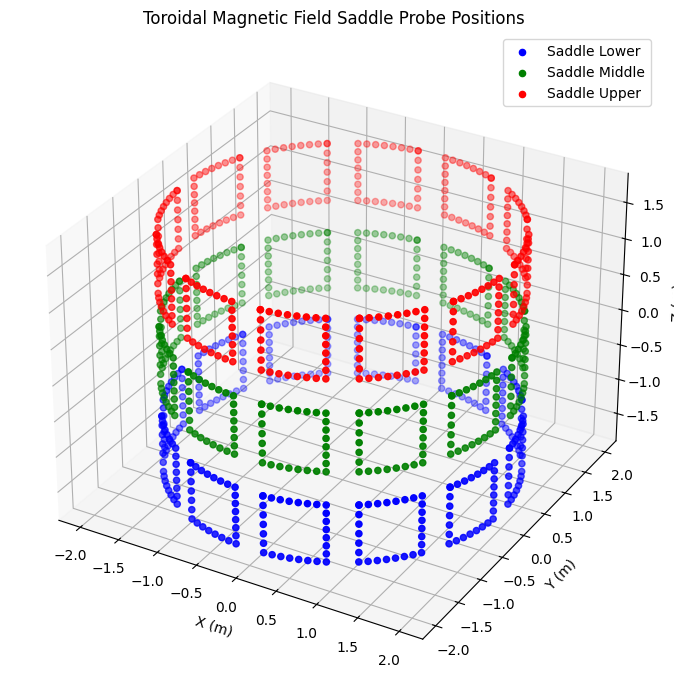

In [4]:
# Extract saddle coil positions (lower, middle, upper)
saddle_data = {
    'Lower': ('b_field_tor_probe_saddle_l', 'blue'),
    'Middle': ('b_field_tor_probe_saddle_m', 'green'), 
    'Upper': ('b_field_tor_probe_saddle_u', 'red')
}

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for level, (var_prefix, color) in saddle_data.items():
    r = ds_mag[f'{var_prefix}_r']
    z = ds_mag[f'{var_prefix}_z'] 
    phi = ds_mag[f'{var_prefix}_phi']
    
    x, y, z_cart = cyl_to_cart(r, phi, z)
    ax.scatter(x, y, z_cart, c=color, label=f'Saddle {level}', s=20)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Toroidal Magnetic Field Saddle Probe Positions")
ax.legend()
plt.tight_layout()
plt.show()

### Pickup Coils

Pickup coils measure poloidal magnetic field. They are arranged in pairs at different toroidal angles.

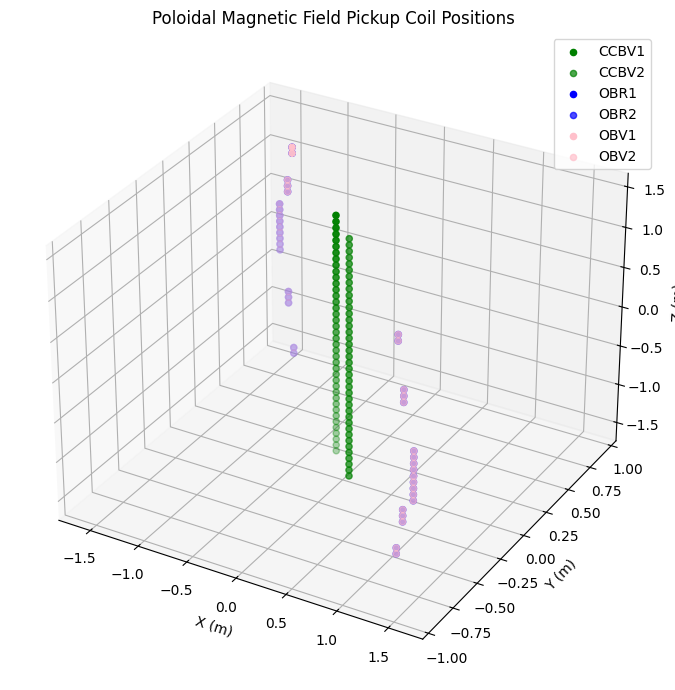

In [5]:
# Pickup coil data - each type has two toroidal positions
pickup_coils = {
    'CCBV': ('b_field_pol_probe_ccbv', 'green'),
    'OBR': ('b_field_pol_probe_obr', 'blue'),
    'OBV': ('b_field_pol_probe_obv', 'pink')
}

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for coil_type, (var_prefix, color) in pickup_coils.items():
    r = ds_mag[f'{var_prefix}_r']
    z = ds_mag[f'{var_prefix}_z']
    phi1 = ds_mag[f'{var_prefix}_phi_1']
    phi2 = ds_mag[f'{var_prefix}_phi_2']
    
    # Plot both toroidal positions
    x1, y1, z1 = cyl_to_cart(r, phi1, z)
    x2, y2, z2 = cyl_to_cart(r, phi2, z)
    
    ax.scatter(x1, y1, z1, c=color, label=f'{coil_type}1', s=20)
    ax.scatter(x2, y2, z2, c=color, label=f'{coil_type}2', s=20, alpha=0.7)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Poloidal Magnetic Field Pickup Coil Positions")
ax.legend()
plt.tight_layout()
plt.show()

### Flux Loops (R-Z cross-section)

Flux loops measure poloidal flux and are positioned around different PF coil locations.

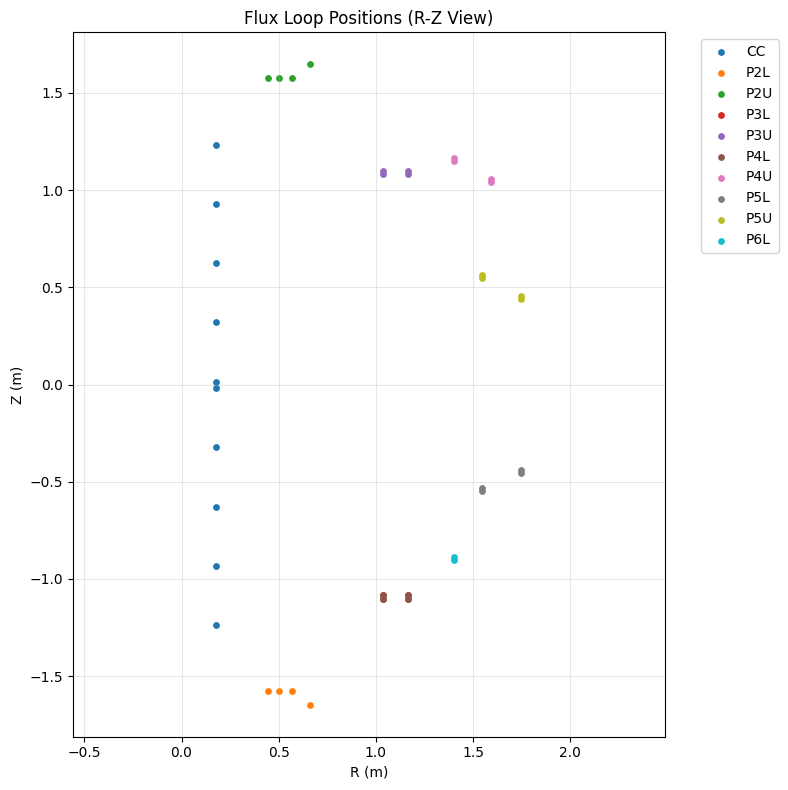

In [6]:
# Get flux loop data
r = ds_mag['flux_loop_r']
z = ds_mag['flux_loop_z']
channels = ds_mag['flux_loop_geometry_channel']

def get_all_flux_loop_coords(channels, r, z, pattern):
    """Get all R,Z coordinates for flux loops matching a pattern"""
    matching_channels = [ch for ch in channels.values if pattern in ch]
    if matching_channels:
        r_vals = []
        z_vals = []
        for channel in matching_channels:
            r_vals.append(r.sel(flux_loop_geometry_channel=channel).values)
            z_vals.append(z.sel(flux_loop_geometry_channel=channel).values)
        return np.array(r_vals), np.array(z_vals)
    return None, None

# Group flux loops by PF coil region
flux_loop_groups = {
    "CC": "FL_CC",      # Central column
    "P2L": "FL_P2L",    # PF coil 2 lower
    "P2U": "FL_P2U",    # PF coil 2 upper
    "P3L": "FL_P3L",    # PF coil 3 lower
    "P3U": "FL_P3U",    # PF coil 3 upper
    "P4L": "FL_P4L",    # PF coil 4 lower
    "P4U": "FL_P4U",    # PF coil 4 upper
    "P5L": "FL_P5L",    # PF coil 5 lower
    "P5U": "FL_P5U",    # PF coil 5 upper
    "P6L": "FL_P6L"     # PF coil 6 lower
}

flux_loops = {}
for label, pattern in flux_loop_groups.items():
    r_vals, z_vals = get_all_flux_loop_coords(channels, r, z, pattern)
    if r_vals is not None:
        flux_loops[label] = (r_vals, z_vals)

# Plot flux loop positions
plt.figure(figsize=(8, 8))
for label, (r_vals, z_vals) in flux_loops.items():
    plt.scatter(r_vals.flatten(), z_vals.flatten(), s=15, label=label)

plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.title("Flux Loop Positions (R-Z View)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

### Mirnov Coils

Mirnov coils are high-frequency magnetic probes used to measure MHD activity.

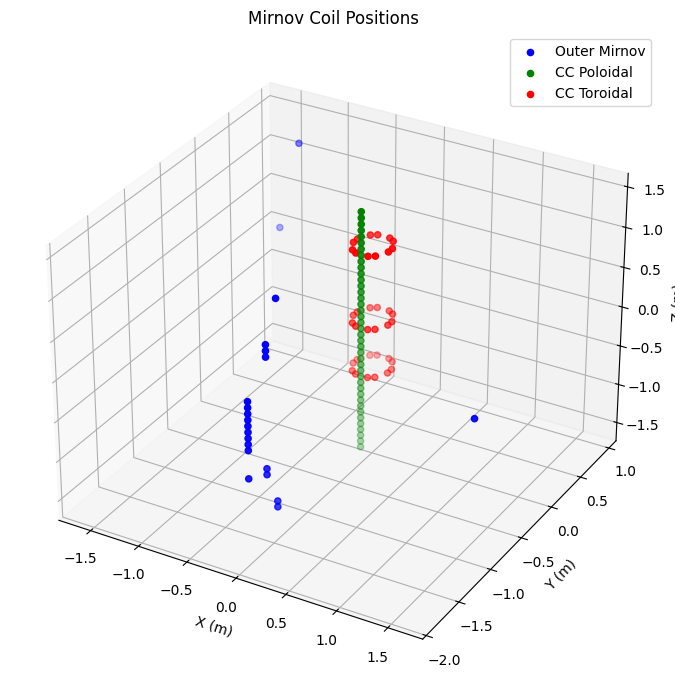

In [7]:
# Mirnov coil types
mirnov_coils = {
    'Outer Mirnov': ('b_field_pol_probe_omv', 'blue'),
    'CC Poloidal': ('b_field_pol_probe_cc', 'green'),
    'CC Toroidal': ('b_field_tor_probe_cc', 'red')
}

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for coil_type, (var_prefix, color) in mirnov_coils.items():
    r = ds_mag[f'{var_prefix}_r']
    z = ds_mag[f'{var_prefix}_z']
    phi = ds_mag[f'{var_prefix}_phi']
    
    x, y, z_cart = cyl_to_cart(r, phi, z)
    ax.scatter(x, y, z_cart, c=color, label=coil_type, s=20)

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("Mirnov Coil Positions")
ax.legend()
plt.tight_layout()
plt.show()

## Poloidal Field (PF) Active Coils

PF coils control the plasma shape and position. Each coil is represented as a collection of rectangular elements.

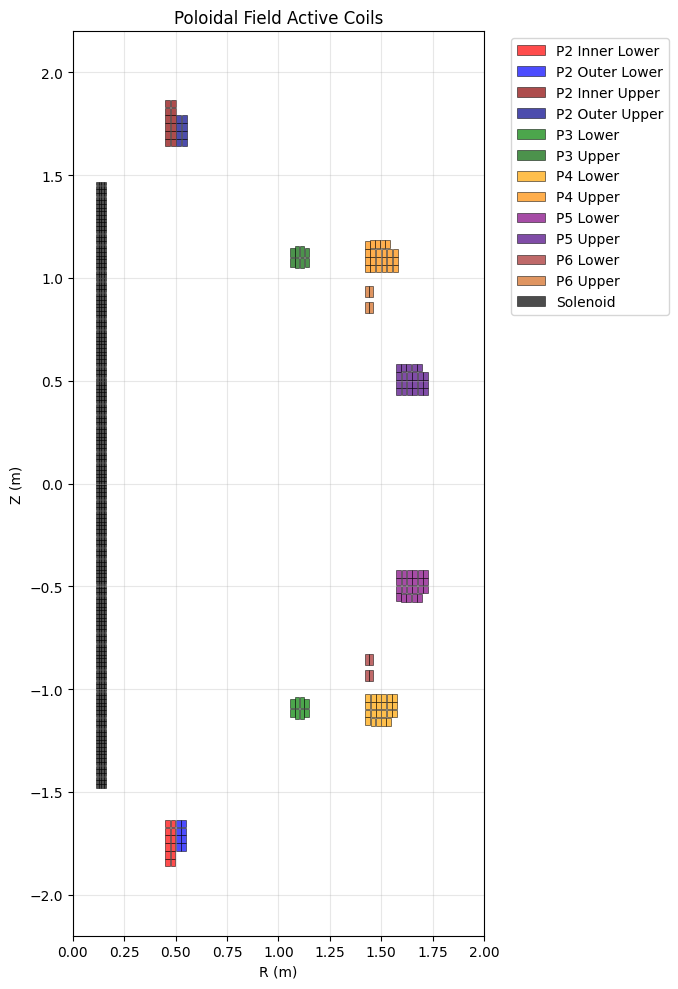

In [8]:
# Load PF active coil data
ds_pf_active = xr.open_zarr(
    "https://s3.echo.stfc.ac.uk/mast/test/james/geometry/30421.zarr",
    group="pf_active",
)

# Define PF coil groups
pf_coils = {
    'P2 Inner Lower': ('p2_inner_lower', 'red'),
    'P2 Outer Lower': ('p2_outer_lower', 'blue'),
    'P2 Inner Upper': ('p2_inner_upper', 'darkred'),
    'P2 Outer Upper': ('p2_outer_upper', 'darkblue'),
    'P3 Lower': ('p3_lower', 'green'),
    'P3 Upper': ('p3_upper', 'darkgreen'),
    'P4 Lower': ('p4_lower', 'orange'),
    'P4 Upper': ('p4_upper', 'darkorange'),
    'P5 Lower': ('p5_lower', 'purple'),
    'P5 Upper': ('p5_upper', 'indigo'),
    'P6 Lower': ('p6_lower', 'brown'),
    'P6 Upper': ('p6_upper', 'chocolate'),
    'Solenoid': ('sol', 'black')
}

fig, ax = plt.subplots(figsize=(12, 10))
legend_added = set()

for coil_name, (var_prefix, color) in pf_coils.items():
    r_arr = np.asarray(ds_pf_active[f'{var_prefix}_r'])
    z_arr = np.asarray(ds_pf_active[f'{var_prefix}_z'])
    w_arr = np.asarray(ds_pf_active[f'{var_prefix}_width'])
    h_arr = np.asarray(ds_pf_active[f'{var_prefix}_height'])
    
    for j, (r, z, w, h) in enumerate(zip(r_arr, z_arr, w_arr, h_arr)):
        if np.isnan(r) or np.isnan(z) or np.isnan(w) or np.isnan(h):
            continue
            
        label_for_legend = coil_name if coil_name not in legend_added else ""
        if coil_name not in legend_added:
            legend_added.add(coil_name)
            
        from matplotlib.patches import Rectangle
        rect = Rectangle((r - w/2, z - h/2), w, h,
                        facecolor=color, edgecolor='black', alpha=0.7, 
                        label=label_for_legend, linewidth=0.5)
        ax.add_patch(rect)

ax.set_xlim(0, 2.0)
ax.set_ylim(-2.2, 2.2)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.set_title("Poloidal Field Active Coils")
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Passive Structure Components

Passive structures include vessel components, supports, and other conducting structures. These use the EFIT element geometry description with potential shape angles for parallelograms.

The below diagram describes the geometry values stored for PF passive, taken from the original MAST plotting code.


                    xxxx     ---             xxxxxxxxxxx
                xxxx   x      |            xx        xx
        --- xxxx       x      |          xx        xx
         |  x          x      dZ       xx        xx
         dZ x       xxxx      |      xx        xx
         |  x   xxxx   ^      |    xx        xx   ^
        --- xxxx    A1 )     --- xxxxxxxxxxxx A2 )
            |----dR----|         |-----dR---|

In [ ]:
def get_element_vertices(centreR, centreZ, dR, dZ, a1, a2, version=0.0, close_shape=False, rotate_90=False):
    """
    Convert EFIT description of rectangles/parallelograms to vertices.
    Based on the MAST geometry implementation.
    
    Parameters:
    - centreR, centreZ: Center position
    - dR, dZ: Width and height
    - a1, a2: Shape angles (degrees, 0 for rectangles)
    - rotate_90: Swap width/height for special cases
    """
    # Handle special rotation for coil cases (coil cases are inherently rotated by 90 degrees at the source file, so needs to be corrected when plotting)
    if rotate_90:
        dR, dZ = dZ, dR

    # Use absolute values to handle negative dimensions
    dR = abs(dR)
    dZ = abs(dZ)

    if a1 == 0.0 and a2 == 0.0:
        # Simple rectangle
        rr = [centreR - dR/2, centreR - dR/2, centreR + dR/2, centreR + dR/2]
        zz = [centreZ - dZ/2, centreZ + dZ/2, centreZ + dZ/2, centreZ - dZ/2]
    else:
        # Parallelogram with angles
        a1_tan = np.tan(a1 * np.pi / 180.0) if a1 > 0.0 else 0.0
        a2_tan = 1.0 / np.tan(a2 * np.pi / 180.0) if a2 > 0.0 else 0.0

        rr = [centreR - dR/2 - dZ/2 * a2_tan,
              centreR + dR/2 - dZ/2 * a2_tan,
              centreR + dR/2 + dZ/2 * a2_tan,
              centreR - dR/2 + dZ/2 * a2_tan]
        
        zz = [centreZ - dZ/2 - dR/2 * a1_tan,
              centreZ - dZ/2 + dR/2 * a1_tan,
              centreZ + dZ/2 + dR/2 * a1_tan,
              centreZ + dZ/2 - dR/2 * a1_tan]
        
    if close_shape:
        rr.append(rr[0])
        zz.append(zz[0])
        
    return (rr, zz)

def plot_passive_component(ax, component_name, ds, color, alpha=0.6):
    """Plot passive component using EFIT geometry calculation"""
    # Get component data
    r_vals = np.atleast_1d(ds[f'{component_name}_r'].values)
    z_vals = np.atleast_1d(ds[f'{component_name}_z'].values)
    w_vals = np.atleast_1d(ds[f'{component_name}_width'].values)
    h_vals = np.atleast_1d(ds[f'{component_name}_height'].values)

    # Get shape angles (default to 0 if not present)
    try:
        a1_vals = np.atleast_1d(ds[f'{component_name}_shapeAngle1'].values)
        a2_vals = np.atleast_1d(ds[f'{component_name}_shapeAngle2'].values)
    except KeyError:
        a1_vals = np.zeros_like(r_vals)
        a2_vals = np.zeros_like(r_vals)
    
    plotted_any = False
    # Special handling for coil cases
    rotate_90 = (component_name == 'coil_cases')
    
    for i, (r, z, w, h, a1, a2) in enumerate(zip(r_vals, z_vals, w_vals, h_vals, a1_vals, a2_vals)):
        if np.isnan(r) or np.isnan(z) or np.isnan(w) or np.isnan(h):
            continue
        if abs(w) < 1e-6 or abs(h) < 1e-6:
            continue

        # Get vertices using EFIT method
        rr, zz = get_element_vertices(r, z, w, h, a1, a2, rotate_90=rotate_90)

        # Create polygon
        vertices = list(zip(rr, zz))
        polygon = Polygon(vertices, facecolor=color, edgecolor='black',
                         alpha=alpha, label=component_name if not plotted_any else '',
                         linewidth=0.5)
        ax.add_patch(polygon)
        plotted_any = True

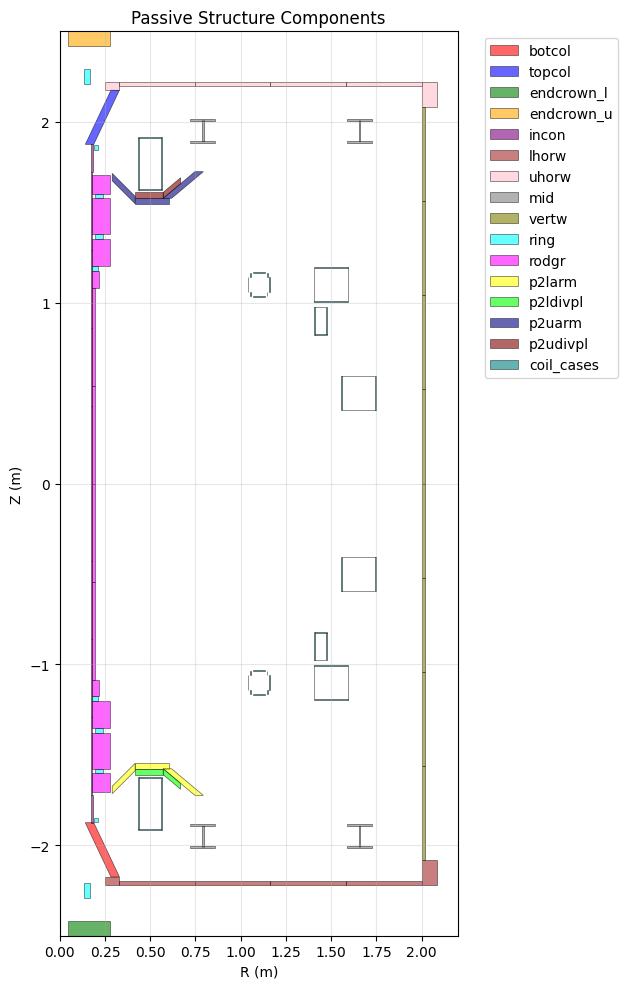

In [10]:
# Load passive structure data
ds_pf_passive = xr.open_zarr(
    "https://s3.echo.stfc.ac.uk/mast/test/james/geometry/30421.zarr",
    group="pf_passive",
)

# Define passive structure components
passive_components = [
    'botcol', 'topcol', 'endcrown_l', 'endcrown_u', 'incon',
    'lhorw', 'uhorw', 'mid', 'vertw', 'ring', 'rodgr',
    'p2larm', 'p2ldivpl', 'p2uarm', 'p2udivpl', 'coil_cases'
]

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink',
          'gray', 'olive', 'cyan', 'magenta', 'yellow', 'lime', 'navy',
          'maroon', 'teal']

for i, component in enumerate(passive_components):
    if f'{component}_r' not in ds_pf_passive.data_vars:
        continue
    color = colors[i % len(colors)]
    plot_passive_component(ax, component, ds_pf_passive, color)

ax.set_xlim(0, 2.2)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')
ax.set_title('Passive Structure Components')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Soft X-ray Diagnostics

It is useful to plot the line-of-sight X ray cams alongside the limiter.

All cameras apart from tangential camera are viewed toroidally when plotted, so if you want to plot the tangential cameras you need to be looking "down" from the top of the tokamak instead of the side like we are with all the other cameras. 

The vertical and tangential cameras also have a LOS that ends at the midpoint (due to the source geometry data). We can extrapolate this to go past the limiter to get a better idea of the LOS up to the limiter.

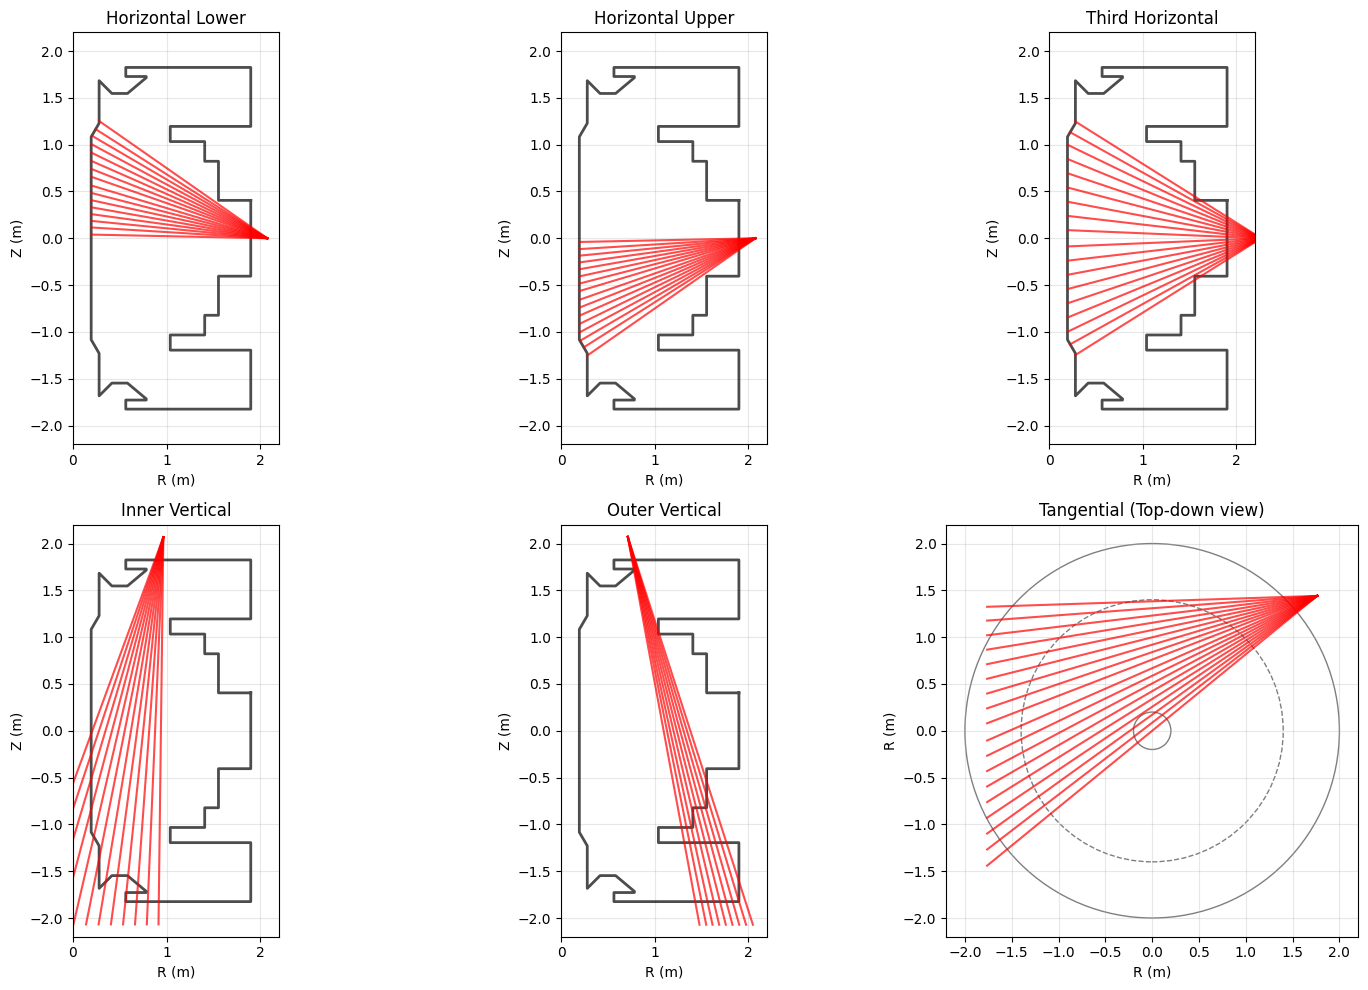

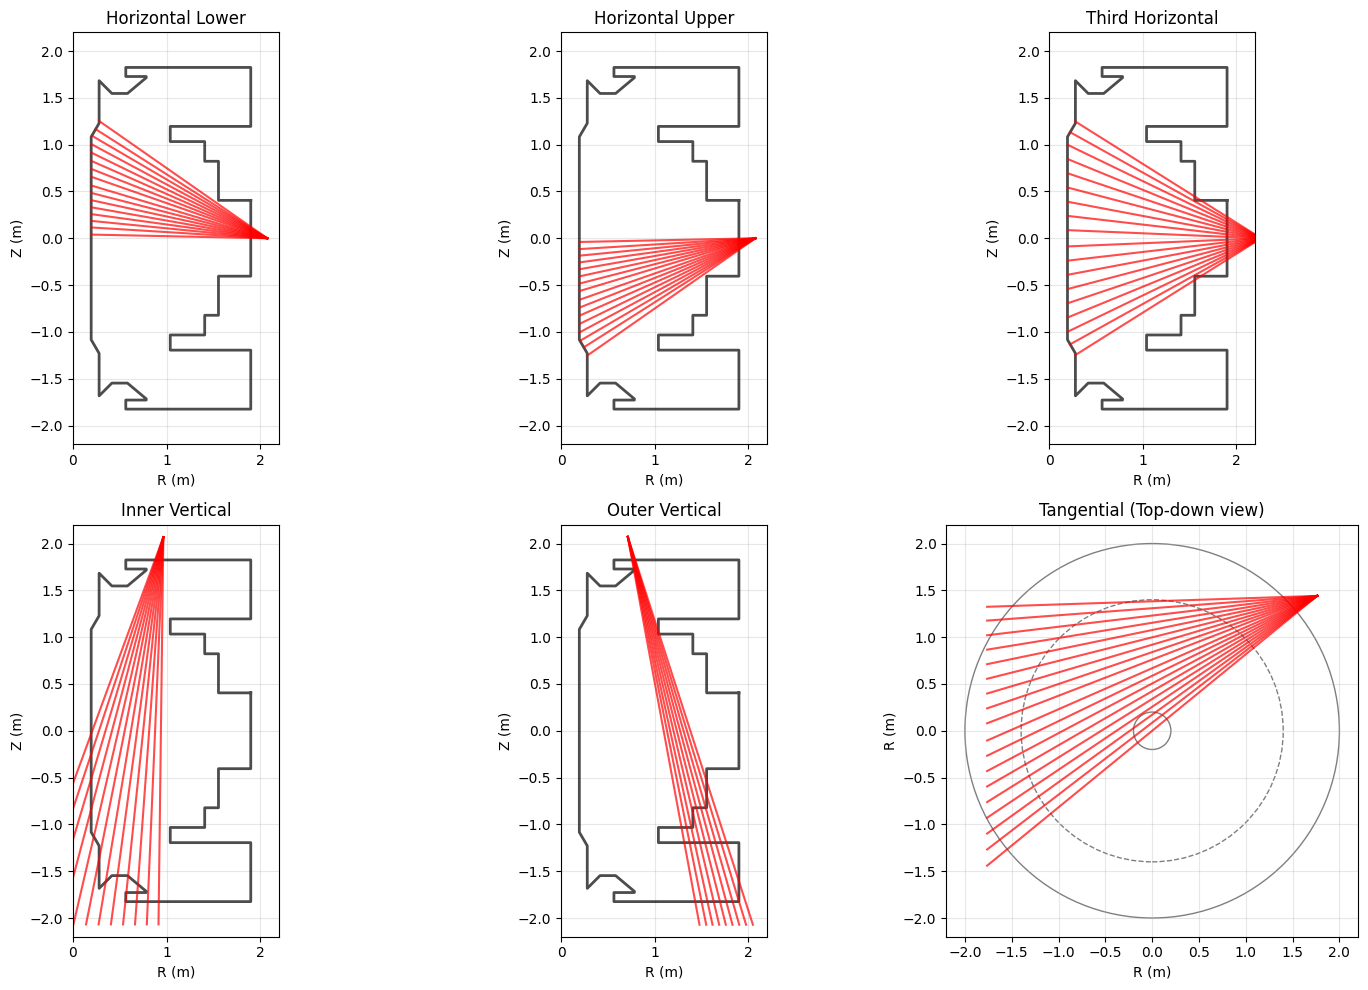

In [38]:
# Load soft X-ray and wall data
ds_xray = xr.open_zarr(
    "https://s3.echo.stfc.ac.uk/mast/test/james/geometry/30421.zarr",
    group="soft_x_rays",
)

ds_wall = xr.open_zarr(
    "https://s3.echo.stfc.ac.uk/mast/test/james/geometry/30421.zarr",
    group="wall",
)

# Camera configurations
cameras = {
    'Horizontal Lower': 'horizontal_cam_lower',
    'Horizontal Upper': 'horizontal_cam_upper', 
    'Third Horizontal': 'third_horizontal_cam',
    'Inner Vertical': 'inner_vertical_cam',
    'Outer Vertical': 'outer_vertical_cam',
    'Tangential': 'tangential_cam'
}

# Create subplot for each camera
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Get limiter data
limiter_r = ds_wall['limiter_r']
limiter_z = ds_wall['limiter_z']

for i, (cam_name, var_prefix) in enumerate(cameras.items()):
    ax = axes[i]
    
    # Get camera line-of-sight data
    try:
        origin_r = ds_xray[f'{var_prefix}_origin_r']
        origin_z = ds_xray[f'{var_prefix}_origin_z']
        endpoint_r = ds_xray[f'{var_prefix}_endpoint_r']
        endpoint_z = ds_xray[f'{var_prefix}_endpoint_z']
    except KeyError:
        ax.text(0.5, 0.5, f'{cam_name}\nData not available', 
               transform=ax.transAxes, ha='center', va='center')
        ax.set_title(cam_name)
        continue
    
    # Special handling for tangential camera (top-down view)
    if cam_name == 'Tangential':
        # Plot tokamak cross-section circles
        for radius in [0.2, 1.4, 2.0]:
            style = "--" if radius == 1.4 else "-"
            circle = plt.Circle((0, 0), radius, fill=False, color="black", 
                              linestyle=style, alpha=0.5)
            ax.add_patch(circle)
        
        # Plot lines of sight (extrapolated)
        scale = 2.0
        for j in range(len(origin_r)):
            dr = endpoint_r[j] - origin_r[j]
            dz = endpoint_z[j] - origin_z[j]
            r1 = origin_r[j] + scale * dr
            z1 = origin_z[j] + scale * dz
            ax.plot([origin_r[j], r1], [origin_z[j], z1], 'r-', alpha=0.7)
        
        ax.set_xlabel('R (m)')
        ax.set_ylabel('R (m)')  # Note: different view
        ax.set_title(f'{cam_name} (Top-down view)')
        ax.set_xlim(-2.2, 2.2)
        ax.set_ylim(-2.2, 2.2)
    else:
        # Plot limiter outline
        ax.plot(limiter_r, limiter_z, 'k-', linewidth=2, alpha=0.7, label='Limiter')
        
        # Plot lines of sight
        extrapolate = 'Vertical' in cam_name
        scale = 2.0 if extrapolate else 1.0
        
        for j in range(len(origin_r)):
            if extrapolate:
                # Extrapolate for vertical cameras
                dr = endpoint_r[j] - origin_r[j]
                dz = endpoint_z[j] - origin_z[j]
                r1 = origin_r[j] + scale * dr
                z1 = origin_z[j] + scale * dz
            else:
                r1, z1 = endpoint_r[j], endpoint_z[j]
            
            ax.plot([origin_r[j], r1], [origin_z[j], z1], 'r-', alpha=0.7)
        
        ax.set_xlabel('R (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(cam_name)
        ax.set_xlim(0, 2.2)
        ax.set_ylim(-2.2, 2.2)
    
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()